# 1. Set enviroment

In [1]:
# Select an interactive backend for plotting
# check all the options by: %matplotlib -l
%matplotlib -l

# I prefer to choose qt5 which will pop up a new window for each plot. 
# Here, for inline presentation, I choose nbagg.
%matplotlib nbagg
# %matplotlib qt5 

# Reload all modules everytime before executing the Python code typed. 
# Sometimes it didnot work. I will reload the script manually by 'reload(pe)'
%load_ext autoreload
%autoreload 2

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'wx', 'qt4', 'qt5', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']


In [2]:
import matplotlib.pylab as plt
import numpy as np
import os, glob, sys
from copy import deepcopy
sys.path.append('/Users/your_user_name/your_folder_for_scripts')
import process_EELS as pe
from importlib import reload
import json

# 2. Load data

In [3]:
# Set the folder where your data is.
folder = '/Users/your_user_name/your_folder_for_data'

# Get all the file names in the folder with a npy format. (I will save SI data in the numpy files.)
# You can change the loading function based on the file format only if the final outputs are numpy arrays.
os.chdir(folder)
file_names = sorted(glob.glob('*.npy')) #'sorted' sorts into alphabetical order
file_names = file_names[:]
for i, f in enumerate(file_names):
    print('{}: {}'.format(i,f))

# Load data into data_list and metadata into metadata_list.
# We will need the metadata files to recontruct the x-axis of the spectra.
# Here, for nionswift, we have .json files as metadata files.
data_list = []
x_list = []
for file in file_names:
    data_list.append(np.load(folder+file))
    with open(folder + file[:-4] +'.json') as json_data:
        metadata = json.load(json_data)
        scale = metadata['spatial_calibrations'][2]['scale']
        offset = metadata['spatial_calibrations'][2]['offset']
        x_list.append(np.linspace(0, data_list[0].shape[2]-1, data_list[0].shape[2]) * scale + offset)

new_data_list = []
for i in range(len(data_list)):
    new_data_list.append([x_list[i], data_list[i]])

0: 1.npy
1: data_with_zlp.npy


# 3. Process Data
### In this session, I will present the basic functions of Line for further analysis.

<IPython.core.display.Javascript object>


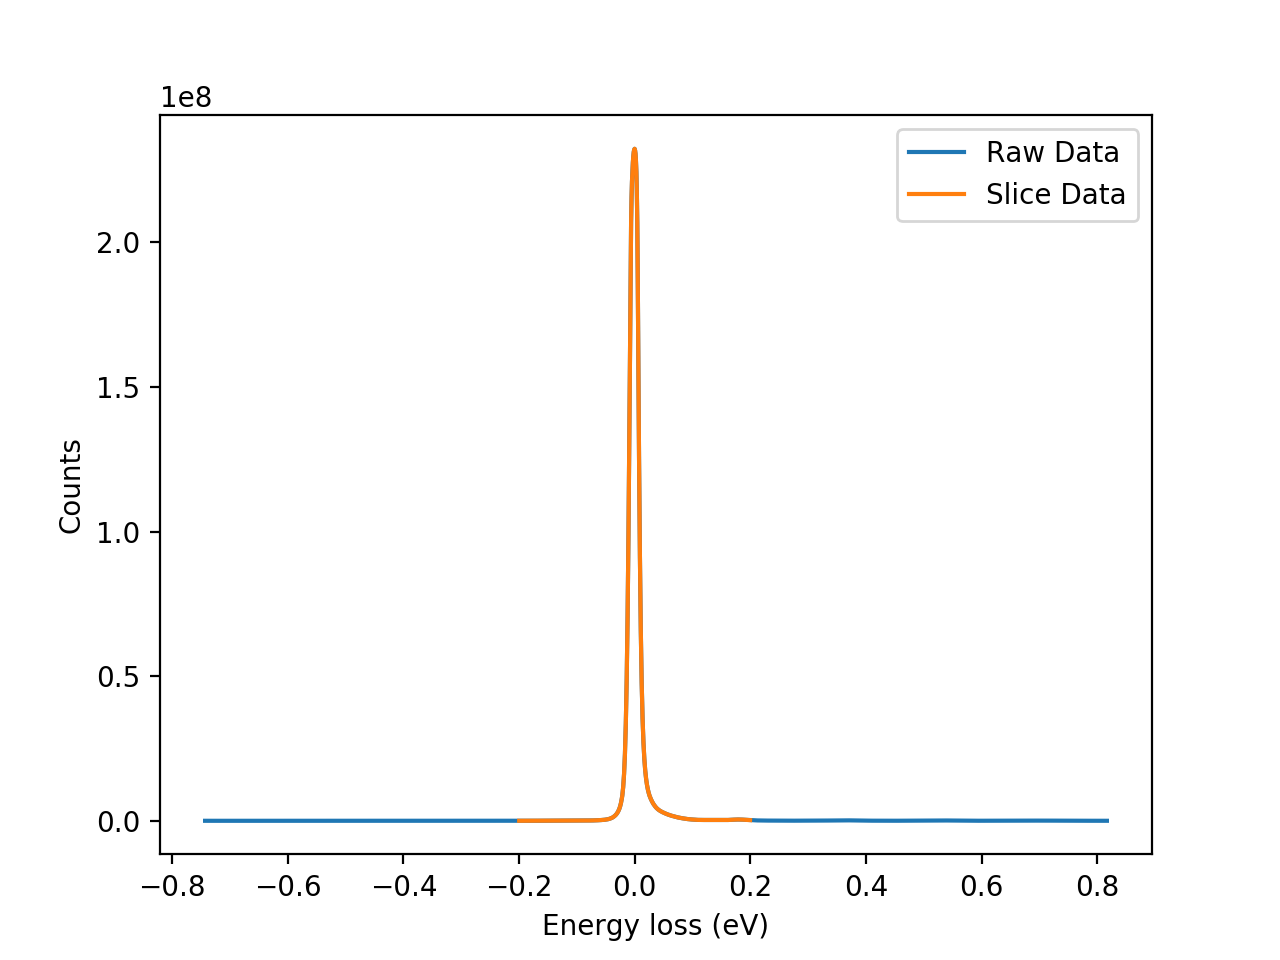

In [4]:
# Example 1: Slice a piece of data by selecting a range in x-axis ('xrange'), and then plot.
reload(pe)
line = pe.Line(new_data_list[0], 'Raw Data')
plt.figure()
xrange = [-0.2, 0.2]
line.plot()
line.data = line.slice_data(xrange)
line.name = 'Slice Data'
line.plot()
plt.legend()

<IPython.core.display.Javascript object>


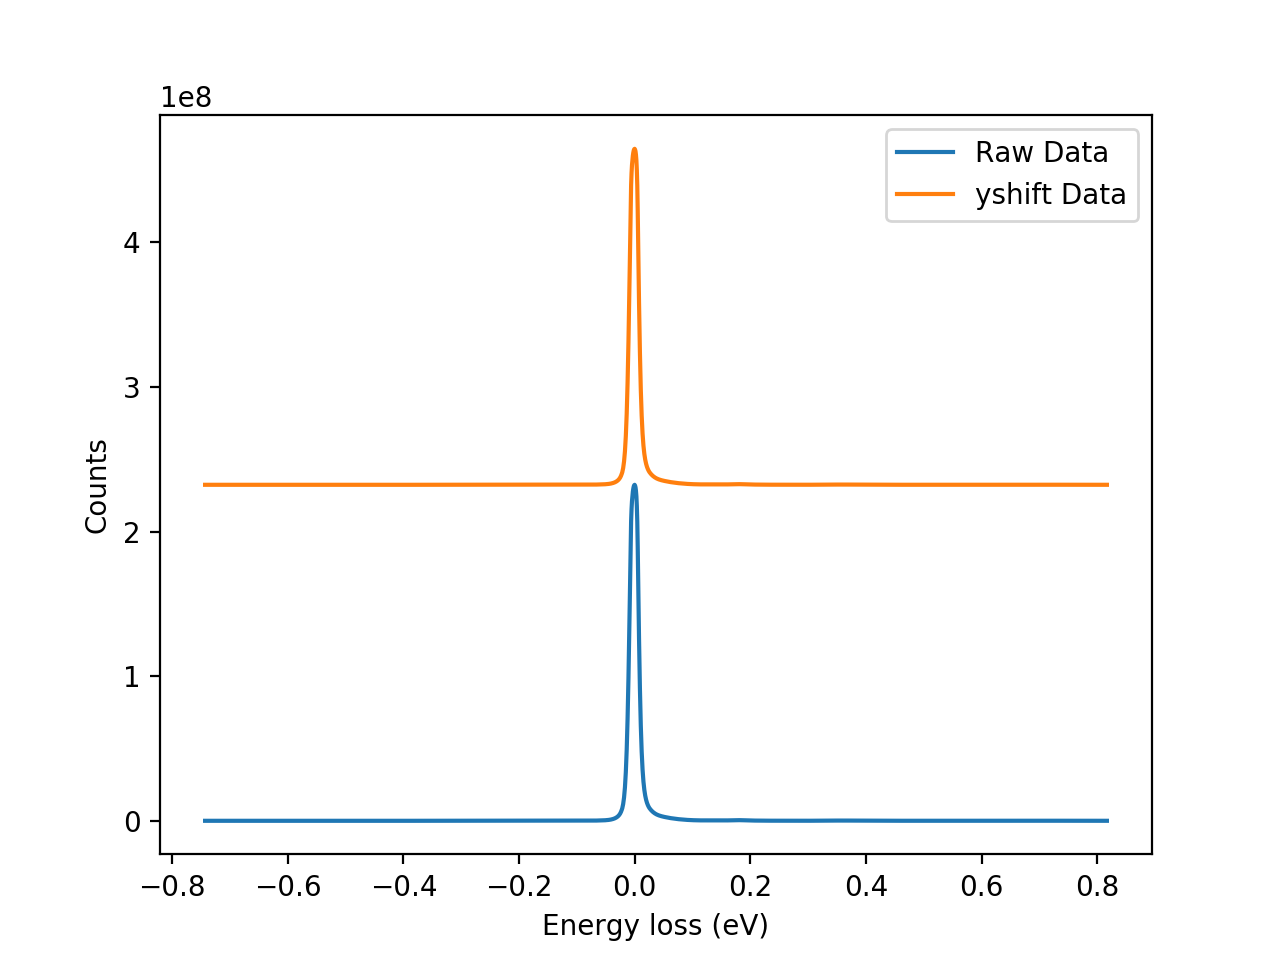

In [5]:
# Example 2: Shift the data in y-axis.
reload(pe)
line = pe.Line(new_data_list[0], 'Raw Data')
plt.figure()
shift = 1 * (max(line.data[1]) - min(line.data[1]))
line.plot()
line.yshift_data(shift)
line.name = 'yshift Data'
line.plot()
plt.legend()

<IPython.core.display.Javascript object>


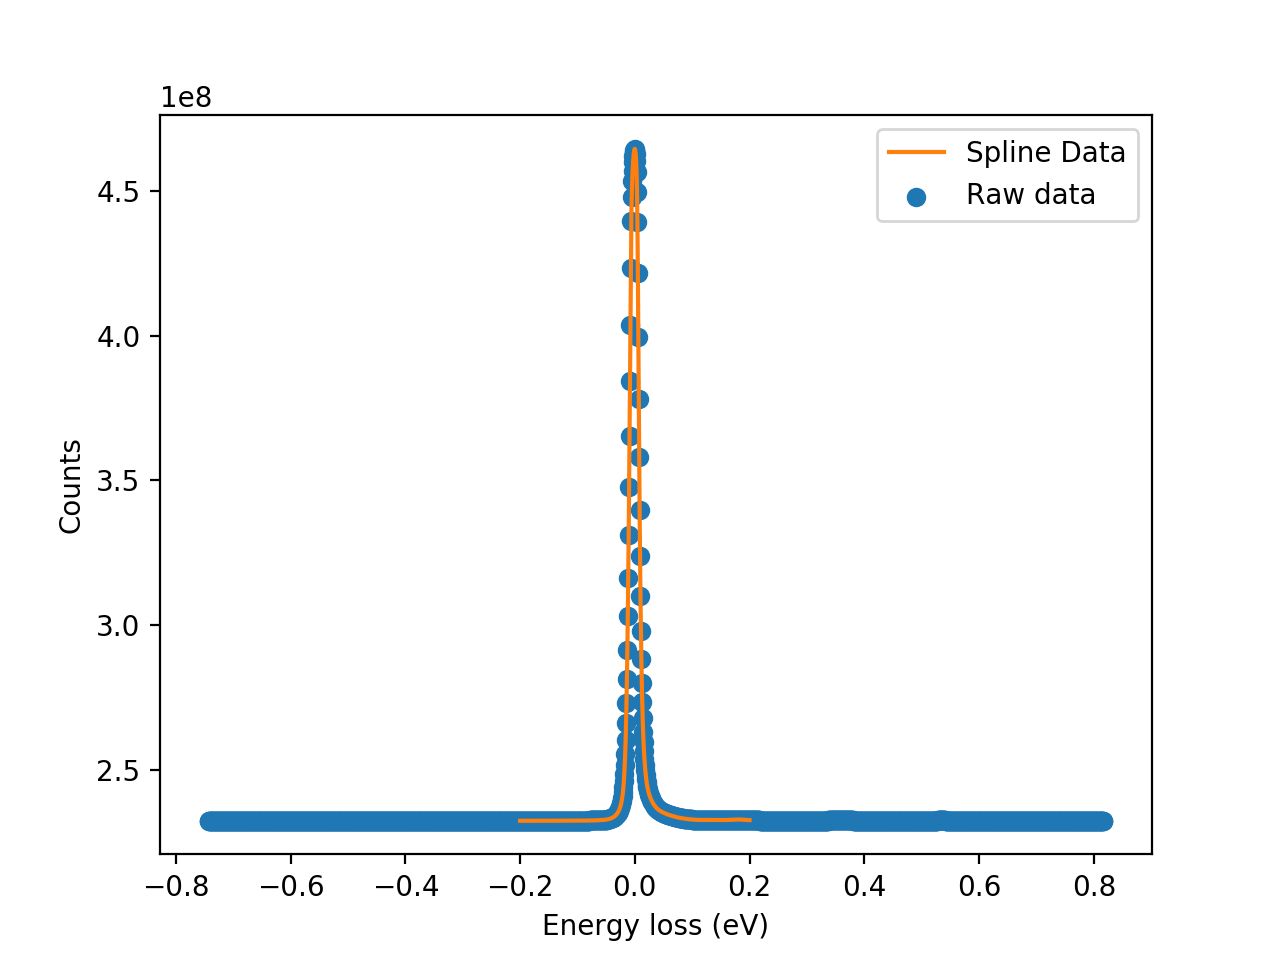

In [6]:
# Example 3: Spline interpolation to generate a continuous curve from discrete data.
# Input of self.spline: raw data, a list of two elements, data[0] for x-values, data[1] for y-values.
# Return of self.spline: a function of the continuous curve ('y_data').
# Usage: Sub-pixel accuracy processing, such as peak finding, ZLP finding, alignment.
# Direction: 
# 1, build an array of discrete x_data between selected range ('xrange') with more densed density than original data.
# 2, get the y values by the function: y_data(x_data)
reload(pe)
line = pe.Line(new_data_list[0], 'Raw Data')
plt.figure()
prop_cycle = plt.rcParams['axes.prop_cycle'] # default colors
colors = prop_cycle.by_key()['color']
plt.scatter(line.data[0], line.data[1], label = 'Raw data')
y_data = line.spline(line.data)
xrange = [-0.2, 0.2]
x_data = line.get_linspace(xrange, num=20000)
line.data = [x_data, y_data(x_data)]
line.name = 'Spline Data'
line.plot(color=colors[1])
plt.legend()

<IPython.core.display.Javascript object>


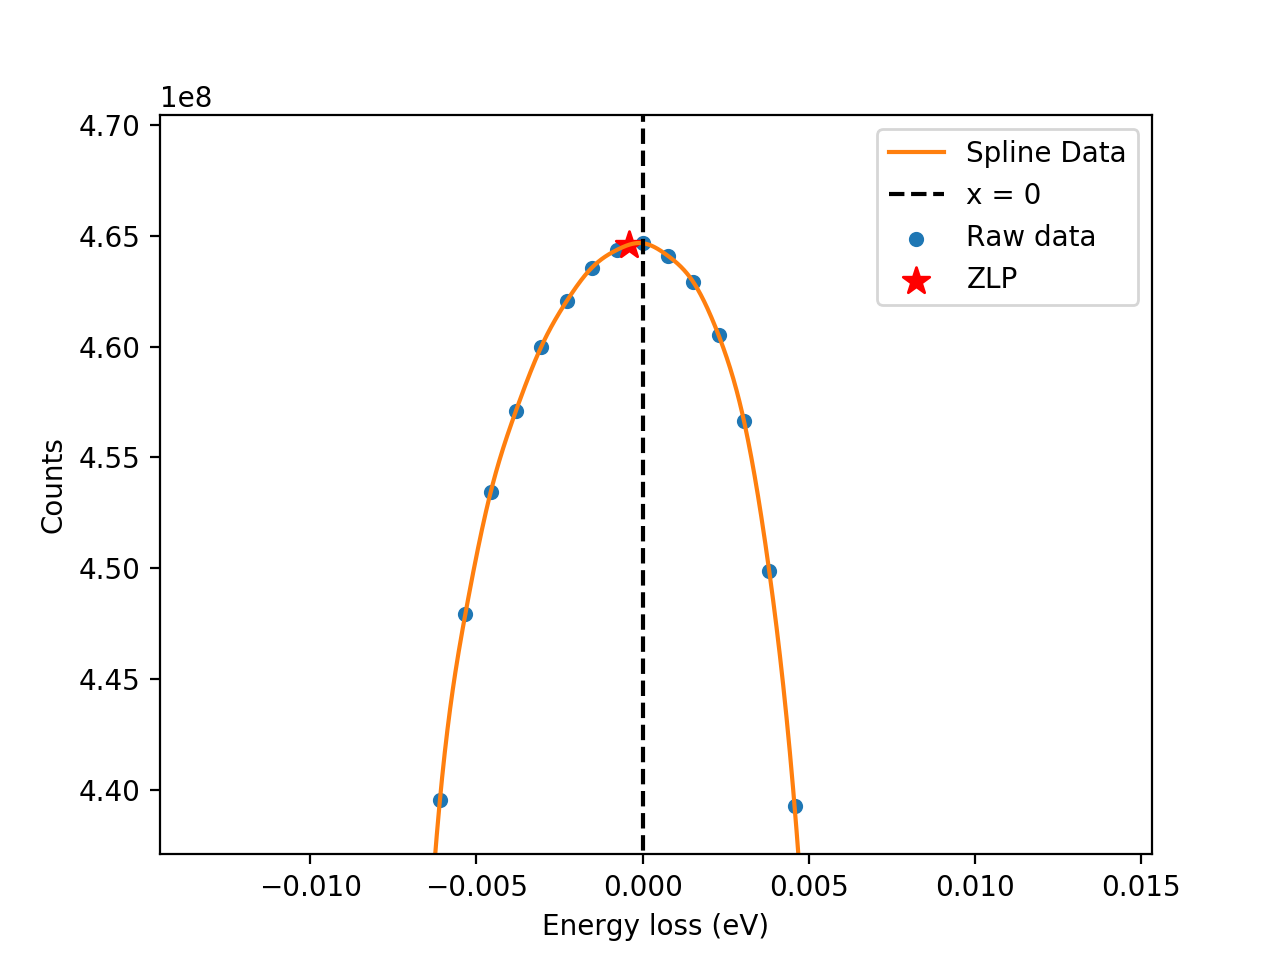

In [7]:
# Example 4: Spline, and then find ZLP by locating the maximum value. 
# (spline function is already implemented in find_zlp_max function)
# Hint: 1, Since the spline is continous and can be used to reconstruct a more densed data set, 
# if the number of points between xrange is large enough, 
# we will get a much more accurate estimate of ZLP position which may locate between two discrete raw data points.
# 2, In find_zlp_max function, it will estimate the rough position by find_peak from scipy.signal first,
# then determine the accurate position with a narrow down area [guess_position - 3*sigma, guess_position + 3*sigma].

# Then 'align' function (not shown here) can be performed, 
# by the x-shifted spline curve function, and the original x-values.
# The accuracy of ZLP alignment depends on the number of points we select for this function.
reload(pe)
line = pe.Line(new_data_list[0], 'Raw Data')
plt.figure()
prop_cycle = plt.rcParams['axes.prop_cycle'] # default colors
colors = prop_cycle.by_key()['color']
plt.scatter(line.data[0], line.data[1], s=20, label = 'Raw data')
y_data = line.spline(line.data)
xrange = [-0.2, 0.2]
x_data = line.get_linspace(xrange, num=20000)
line.data = [x_data, y_data(x_data)]
line.name = 'Spline Data'
line.plot(color=colors[1])
shift, height = line.find_zlp_max()
plt.scatter(shift, height, s=100, marker='*', color='r',label='ZLP')
plt.plot([0,0],[min(line.data[1]), 1.02*max(line.data[1])],'k--',label='x = 0')
plt.xlim(xrange)
plt.ylim([min(line.data[1]), 1.02*max(line.data[1])])
plt.legend()

<IPython.core.display.Javascript object>


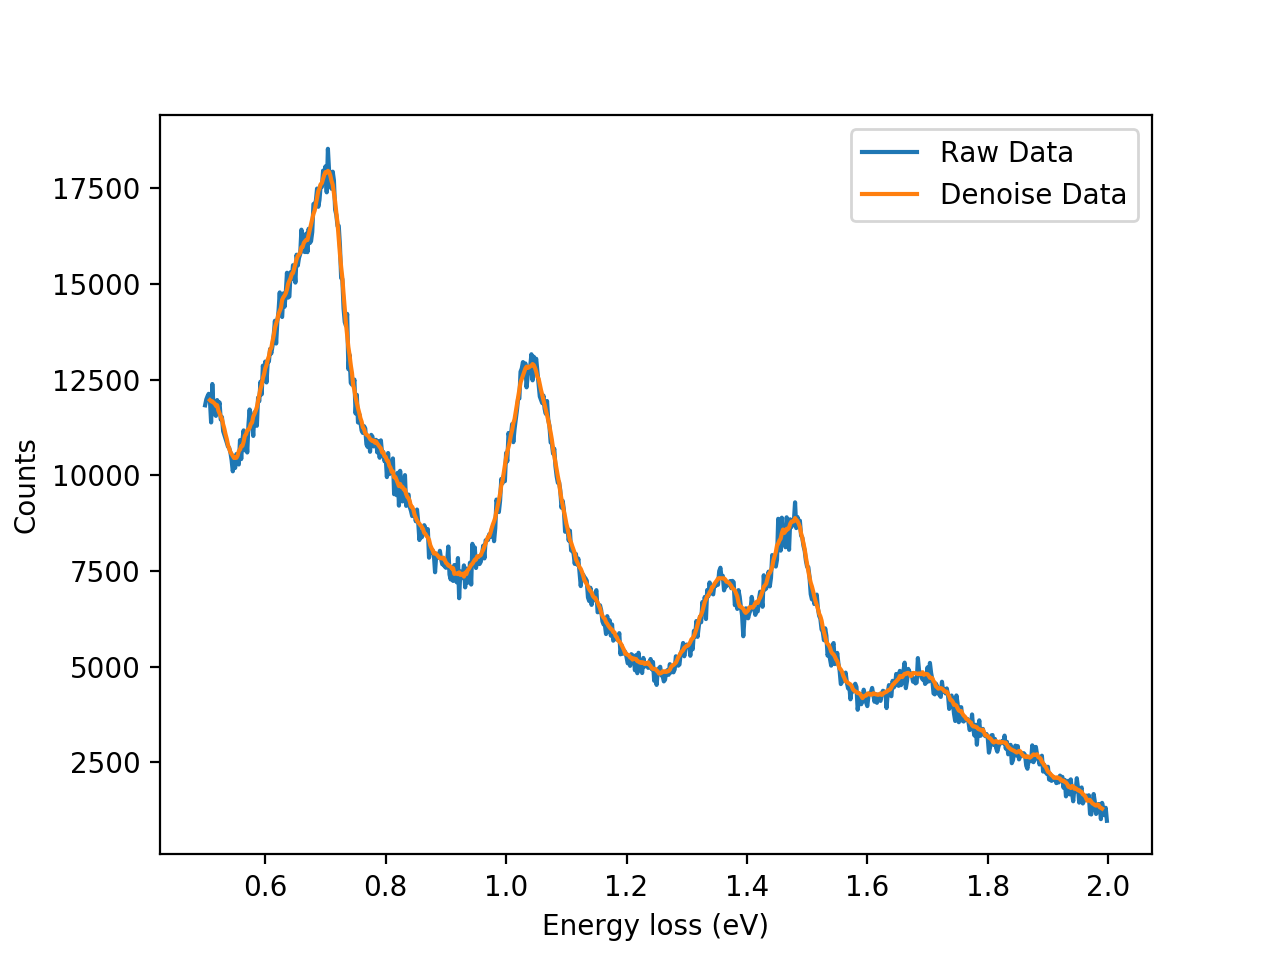

In [8]:
# Example 5: denoise by Local low rank (LLR) 
# Ref: J. Spiegelberg et al., Ultramicroscopy 187, 34-42 (2018) 
# DOI: 10.1016/j.ultramic.2018.01.012
reload(pe)
xrange = [0.5,2]
line = pe.Line(new_data_list[1], 'Raw Data')
plt.figure()
line.data = line.slice_data(xrange)
line.plot()
x, sm_y = line.denoise_LLR(0.02)
plt.plot(x, sm_y,label='Denoise Data')
plt.legend()

<IPython.core.display.Javascript object>


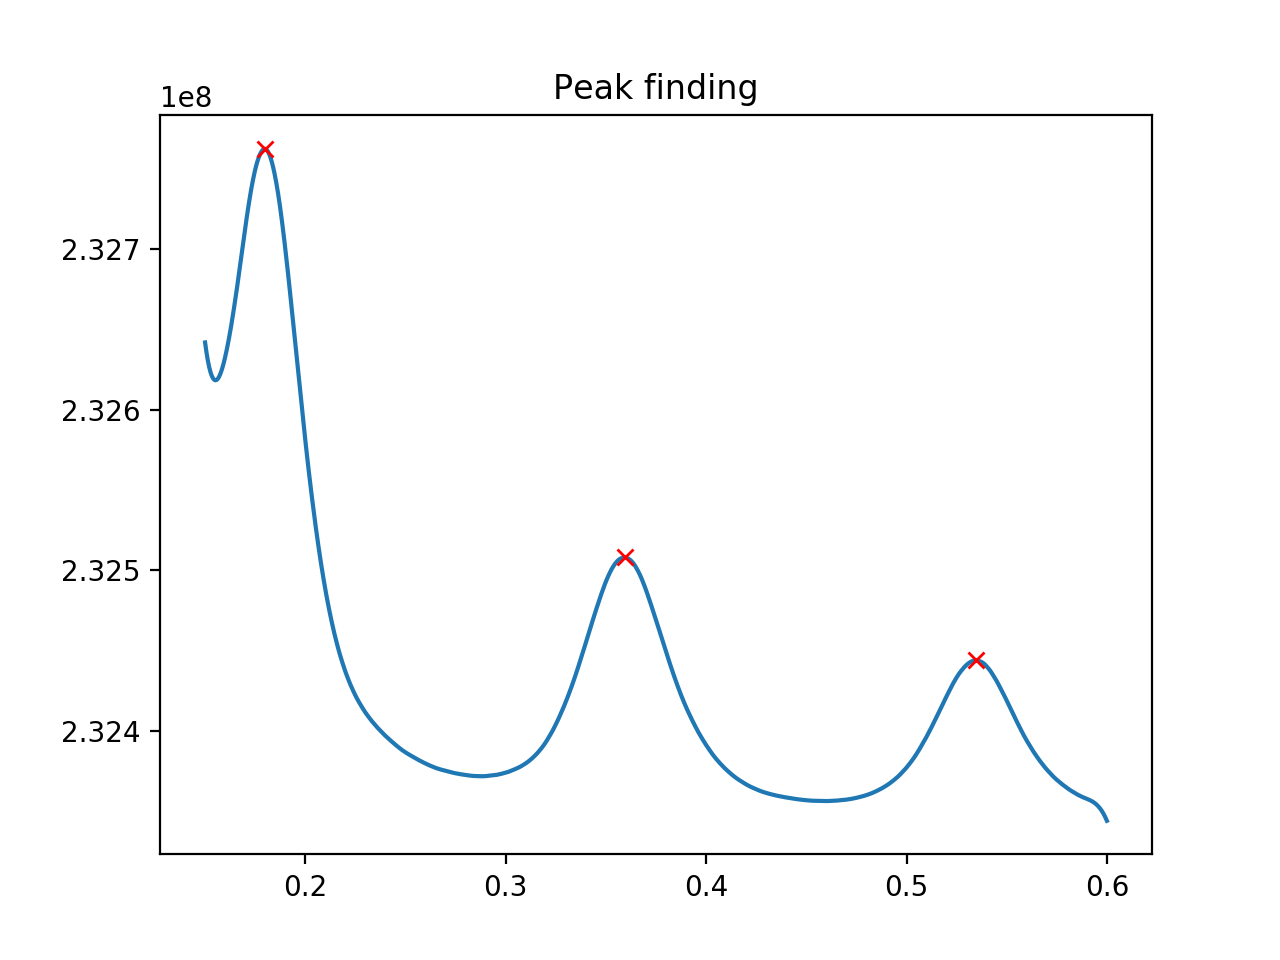

Peak positions for Raw Data: [0.17971486 0.35935468 0.53471736]
Height Raw Data: [2.32762559e+08 2.32507975e+08 2.32443847e+08]


In [9]:
# Example 6: denoise, spline, and then find peaks. 
# Cannot include ZLP due to denoising. Even better after ZLP extraction.
# This function will estimate the rough peaks first, then determine positions with defined prominence and distance.
reload(pe)
xrange = [0.15,0.6]
line = pe.Line(new_data_list[0], 'Raw Data')
config_find_peak = {'height': min(new_data_list[0][1])/2,
                    'distance': 1 / 100,
                    'prominence': 1 / 10000,
                    'display_peaks': True,
                   }
peaks, heights = line.find_peak(xrange, config_find_peak)
print('Peak positions for {}: {}'.format(line.name, peaks))
print('Height {}: {}'.format(line.name, heights))